# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

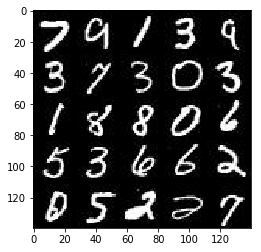

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

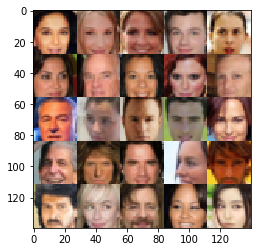

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [30]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(x1, x1*alpha)
#         print(x1.get_shape())
        
        x2 = tf.layers.conv2d(x1, 112, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*alpha)
#         print(x2.get_shape())
        
        x3 = tf.layers.conv2d(x2, 224, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3*alpha)
#         print(x3.get_shape())
        
        flat = tf.reshape(x3, (-1, 4*4*224))
        
        logits = tf.layers.dense(flat, 1)
#         print(logits.get_shape())
        
        out = tf.sigmoid(logits)
#         out = tf.nn.dropout(out, keep_prob=0.9)
        
        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        
        x1 = tf.reshape(x1, (-1,3,3,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, x1 * alpha)
#         print(x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, x2 * alpha)
#         print(x2.get_shape())
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, x3 * alpha)
#         print(x3.get_shape())
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4, x4 * alpha)
#         print(x4.get_shape())
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
#         print(logits.get_shape())
        
        out = tf.tanh(logits)
#         out = tf.nn.dropout(out, keep_prob=0.5)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)*smooth))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
#     sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    show_every = 100
    print_every = 10
    step = 0
    samples, losses = [], []
    
    img_height = data_shape[1]
    img_width = data_shape[2]
    img_depth = data_shape[3]
    
    input_real, input_z, lr = model_inputs(img_height, img_width, img_depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        show_generator_output(sess, 20, input_z, img_depth, data_image_mode)
        saver = tf.train.Saver()
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                # show image at start
                
                
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                

                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, 20, input_z, img_depth, data_image_mode)
                
        saver.save(sess, './checkpoints/generator.ckpt')       
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
!mkdir 'checkpoints'

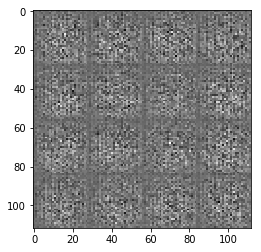

Epoch 1/2... Discriminator Loss: 2.2141... Generator Loss: 0.4629
Epoch 1/2... Discriminator Loss: 1.7750... Generator Loss: 0.4924
Epoch 1/2... Discriminator Loss: 0.7713... Generator Loss: 2.0538
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.5327
Epoch 1/2... Discriminator Loss: 0.7501... Generator Loss: 1.1694
Epoch 1/2... Discriminator Loss: 1.8726... Generator Loss: 0.6225


KeyboardInterrupt: 

In [32]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

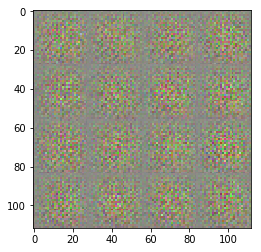

Epoch 1/1... Discriminator Loss: 4.5167... Generator Loss: 0.3706
Epoch 1/1... Discriminator Loss: 2.8470... Generator Loss: 0.4190
Epoch 1/1... Discriminator Loss: 1.5783... Generator Loss: 1.4316
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 2.1927
Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 2.0857... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.7695


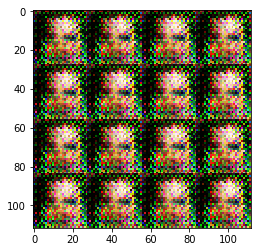

Epoch 1/1... Discriminator Loss: 0.5298... Generator Loss: 2.2159
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 1.4874
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 0.5608... Generator Loss: 2.4878
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 1.8699
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.7045
Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 2.0658
Epoch 1/1... Discriminator Loss: 0.6274... Generator Loss: 1.6584


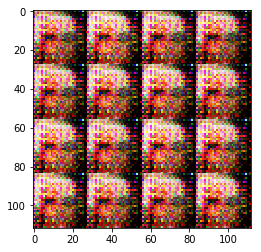

Epoch 1/1... Discriminator Loss: 2.0363... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.6524... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.8251... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.7662... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.5907... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.6479... Generator Loss: 1.3486
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.8067


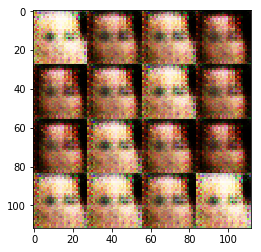

Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.3458
Epoch 1/1... Discriminator Loss: 1.5816... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.7853... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.6480... Generator Loss: 0.5930


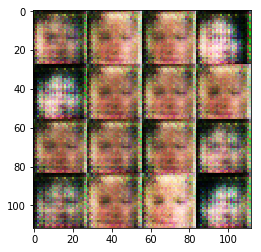

Epoch 1/1... Discriminator Loss: 1.8290... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.7049... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.5506... Generator Loss: 0.7215


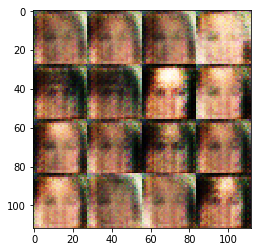

Epoch 1/1... Discriminator Loss: 1.7791... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.7831... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.6941


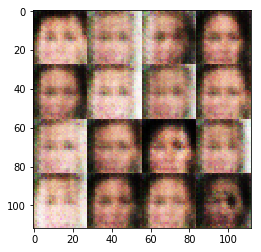

Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.6831


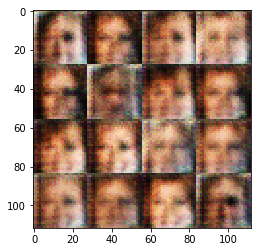

Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.7216


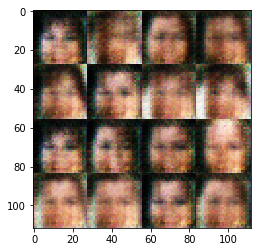

Epoch 1/1... Discriminator Loss: 1.6344... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7973


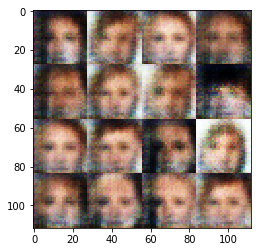

Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7558


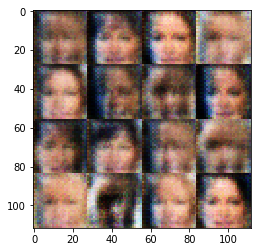

Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7523


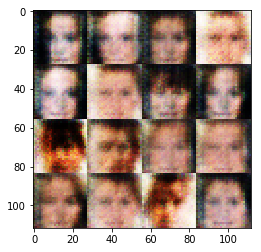

Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6890


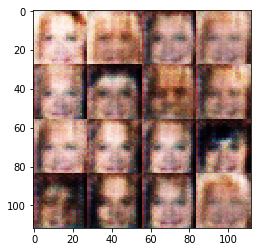

Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7377


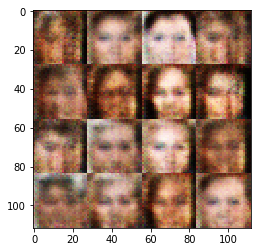

Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7523


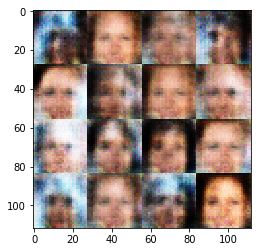

Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7242


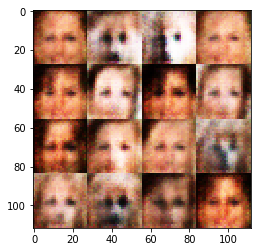

Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7617


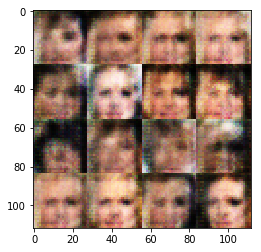

Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7353


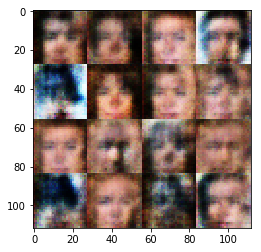

Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.7159


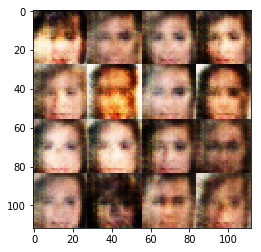

Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7307


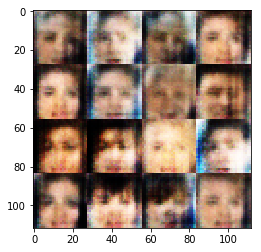

Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7600


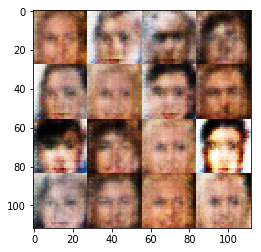

Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7467


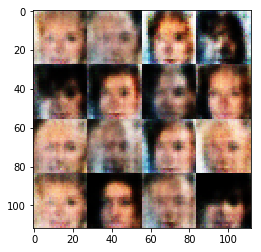

Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7198


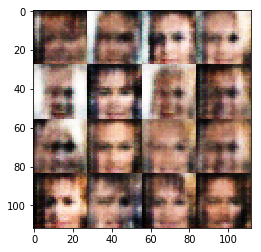

Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7343


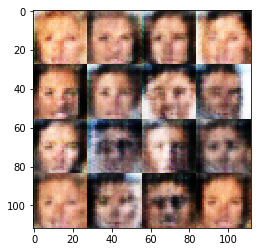

Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7700


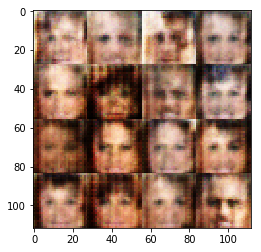

Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8395


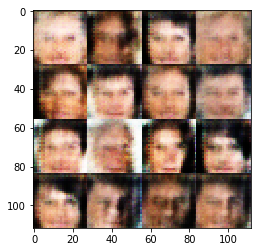

Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7486


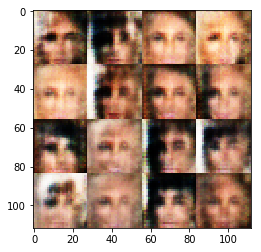

Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.8017


KeyboardInterrupt: 

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.